In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the dataset.

In [3]:
!gdown --id 1ZMvSbs6-ts0GqRZNV3CcPUPK8z99AiBD

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZMvSbs6-ts0GqRZNV3CcPUPK8z99AiBD
To: /content/GHG gases.csv
100% 8.11k/8.11k [00:00<00:00, 33.3MB/s]


In [4]:
!gdown --id 1cO1AdYenzGFeMqoAhnRI6plzw8AyMFjB

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cO1AdYenzGFeMqoAhnRI6plzw8AyMFjB
To: /content/lstm4.csv
100% 7.98k/7.98k [00:00<00:00, 37.1MB/s]


In [5]:
!gdown --id 1QYV7fxbyGnEpI1rymSO-JnZFORbR1Gzi

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QYV7fxbyGnEpI1rymSO-JnZFORbR1Gzi
To: /content/lstm5.csv
100% 487/487 [00:00<00:00, 3.41MB/s]


In [6]:
GHG = pd.read_csv('GHG gases.csv')

In [7]:
columns_to_convert = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
                       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
                       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

GHG[columns_to_convert] = GHG[columns_to_convert].replace({',': ''}, regex=True).fillna(-1).apply(pd.to_numeric, errors='coerce')

problematic_column = columns_to_convert[0]
unique_values = GHG[problematic_column].unique()
for value in unique_values:
    print(f"Value: {value}, Type: {type(value)}")


Value: 55978.4, Type: <class 'numpy.float64'>
Value: 50762.1, Type: <class 'numpy.float64'>
Value: 176067.9, Type: <class 'numpy.float64'>
Value: 217638.6, Type: <class 'numpy.float64'>
Value: 75232.5, Type: <class 'numpy.float64'>
Value: 5786.8, Type: <class 'numpy.float64'>
Value: 12127.0, Type: <class 'numpy.float64'>
Value: 66667.4, Type: <class 'numpy.float64'>
Value: 3139.2, Type: <class 'numpy.float64'>
Value: 1199.4, Type: <class 'numpy.float64'>
Value: 345.0, Type: <class 'numpy.float64'>
Value: 645.9, Type: <class 'numpy.float64'>
Value: 2568.7, Type: <class 'numpy.float64'>
Value: 2934.8, Type: <class 'numpy.float64'>
Value: 12375.8, Type: <class 'numpy.float64'>
Value: 6393.0, Type: <class 'numpy.float64'>
Value: 6151.5, Type: <class 'numpy.float64'>
Value: 1797.7, Type: <class 'numpy.float64'>
Value: 1162.8, Type: <class 'numpy.float64'>
Value: 76.3, Type: <class 'numpy.float64'>
Value: 143893.7, Type: <class 'numpy.float64'>


In [8]:
GHG.describe()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,40140.214286,40597.923810,39686.528571,38851.842857,38329.947619,38137.242857,39390.180952,38634.080952,38853.361905,37385.671429,...,31246.795238,30599.642857,29093.666667,28601.014286,27565.590476,26817.166667,26864.023810,26218.280952,23266.495238,23942.219048
std,63833.684792,64202.103931,61769.957283,59492.887159,58790.253504,57879.744424,59600.863064,57683.659421,58049.720188,55588.152038,...,51084.188897,50030.384273,46122.335824,44495.597219,42317.249901,40874.116465,41159.039528,40059.229572,35328.312346,36965.332110
min,76.300000,75.100000,76.800000,78.200000,81.900000,83.400000,81.600000,84.300000,81.000000,80.500000,...,47.300000,41.900000,46.400000,42.500000,51.600000,46.200000,47.600000,47.700000,31.500000,40.700000
25%,1797.700000,1885.400000,1712.900000,1793.500000,1739.300000,1737.800000,1793.200000,1629.000000,1550.400000,1483.600000,...,1068.900000,1059.300000,979.000000,1011.200000,1035.800000,1022.200000,1007.700000,1002.600000,880.000000,954.800000
50%,6151.500000,6471.100000,6828.400000,6124.100000,6391.000000,6424.000000,6677.600000,6857.200000,6284.400000,5891.600000,...,5427.200000,5786.200000,5169.500000,4807.500000,4713.400000,4654.400000,4721.900000,4632.500000,3868.300000,4441.000000
75%,55978.400000,55808.500000,55510.400000,54725.400000,55487.300000,55391.700000,56706.200000,56132.400000,55674.800000,55680.500000,...,32164.500000,29286.800000,27392.900000,27221.500000,27117.400000,28111.600000,28407.500000,27934.300000,26552.400000,26551.400000
max,217638.600000,214348.200000,202484.400000,185006.100000,180725.000000,178167.000000,177971.400000,166017.900000,170829.800000,163215.000000,...,178586.400000,169386.400000,148443.900000,139976.400000,142422.100000,141389.900000,144174.100000,140918.000000,125152.700000,134761.900000


In [10]:
df = pd.read_csv('lstm5.csv', index_col='Date', parse_dates=True)
df.index.freeq='YS'
df1 = pd.read_csv('lstm4.csv', index_col='Date', parse_dates=True)
df1.index.freeq='YS'

In [11]:

columns_to_convert = ['Agriculture, forestry and fishing', 'Mining and quarrying', 'Manufacturing', 'Electricity, gas, steam and air conditioning supply', 'Water supply; sewerage, waste management and remediation activities', 'Construction', 'Wholesale and retail trade; repair of motor vehicles and motorcycles', 'Transport and storage', 'Accommodation and food services', 'Information and communication', 'Financial and insurance activities', 'Real estate activities', 'Professional, scientific and technical activities', 'Administrative and support service activities', 'Public administration and defence; compulsory social security', 'Education', 'Human health and social work activities', 'Arts, entertainment and recreation', 'Other service activities', 'Activities of households as employers; undifferentiated goods and services-producing activities of households for own use', 'Consumer expenditure', 'Total']

df1[columns_to_convert] = df1[columns_to_convert].replace({',': '', '[^\d.]': ''}, regex=True).fillna(-1).apply(pd.to_numeric, errors='coerce')

problematic_column = columns_to_convert[0]
unique_values = df1[problematic_column].unique()
for value in unique_values:
    print(f"Value: {value}, Type: {type(value)}")

Value: 55978.4, Type: <class 'numpy.float64'>
Value: 55808.5, Type: <class 'numpy.float64'>
Value: 55510.4, Type: <class 'numpy.float64'>
Value: 54725.4, Type: <class 'numpy.float64'>
Value: 55487.3, Type: <class 'numpy.float64'>
Value: 55391.7, Type: <class 'numpy.float64'>
Value: 56706.2, Type: <class 'numpy.float64'>
Value: 56132.4, Type: <class 'numpy.float64'>
Value: 55674.8, Type: <class 'numpy.float64'>
Value: 55680.5, Type: <class 'numpy.float64'>
Value: 53597.6, Type: <class 'numpy.float64'>
Value: 51258.6, Type: <class 'numpy.float64'>
Value: 50997.8, Type: <class 'numpy.float64'>
Value: 51437.4, Type: <class 'numpy.float64'>
Value: 52171.6, Type: <class 'numpy.float64'>
Value: 52218.2, Type: <class 'numpy.float64'>
Value: 51150.6, Type: <class 'numpy.float64'>
Value: 50809.6, Type: <class 'numpy.float64'>
Value: 50472.9, Type: <class 'numpy.float64'>
Value: 49684.2, Type: <class 'numpy.float64'>
Value: 49685.0, Type: <class 'numpy.float64'>
Value: 48994.2, Type: <class 'nump

In [12]:
df1[:32]

,"Agriculture, forestry and fishing",Mining and quarrying,Manufacturing,"Electricity, gas, steam and air conditioning supply","Water supply; sewerage, waste management and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transport and storage,Accommodation and food services,Information and communication,...,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defence; compulsory social security,Education,Human health and social work activities,"Arts, entertainment and recreation",Other service activities,Activities of households as employers; undifferentiated goods and services-producing activities of households for own use,Consumer expenditure,Total
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,55978.4,50762.1,176067.9,217638.6,75232.5,5786.8,12127.0,66667.4,3139.2,1199.4,...,2568.7,2934.8,12375.8,6393.0,6151.5,1797.7,1162.8,76.3,143893.7,842944.5
1991-01-01,55808.5,50877.2,177032.4,214348.2,76756.7,5946.2,12490.8,67119.0,3550.4,1272.6,...,2767.7,3060.6,11673.3,6714.7,6471.1,1885.4,1251.9,75.1,152359.2,852556.4
1992-01-01,55510.4,51480.6,170118.3,202484.4,76870.8,6058.3,12324.7,68163.3,3270.5,1241.8,...,2672.5,3024.1,11826.0,6845.3,6828.4,1712.9,1191.3,76.8,150676.4,833417.1
1993-01-01,54725.4,51092.0,165079.3,185006.1,77189.4,6124.1,12571.6,69528.8,3475.9,1293.1,...,2564.0,3119.4,12017.5,5948.6,6509.5,1793.5,1249.9,78.2,155426.7,815888.7
1994-01-01,55487.3,44876.2,168003.9,180725.0,77556.2,6391.0,12970.1,70523.6,3453.5,1336.3,...,2614.2,3217.2,11377.5,5427.6,6587.7,1739.3,1241.8,81.9,150210.3,804928.9
1995-01-01,55391.7,46739.8,166085.4,178167.0,78634.3,6424.0,13152.4,73415.5,3560.8,1376.2,...,2693.1,3275.3,11385.5,5135.8,6497.4,1737.8,1272.8,83.4,144708.1,800882.1
1996-01-01,56706.2,46903.0,167363.6,177971.4,79137.0,6677.6,13486.1,79112.2,3742.7,1379.5,...,2716.4,3339.9,11175.2,6287.7,7042.7,1793.2,1326.1,81.6,159770.4,827193.8
1997-01-01,56132.4,46035.6,166017.9,164572.8,77930.1,6914.9,13410.2,88152.6,3362.0,1314.1,...,2535.3,3282.8,10690.6,6857.2,6241.4,1629.0,1216.1,84.3,153848.3,811315.7
1998-01-01,55674.8,44644.9,158150.0,170829.8,78942.1,7130.9,13778.1,93145.3,3542.4,1331.1,...,2596.8,3319.7,10213.5,6013.3,6284.4,1550.4,1209.8,81.0,156346.7,815920.6


In [13]:
df1.describe()

,"Agriculture, forestry and fishing",Mining and quarrying,Manufacturing,"Electricity, gas, steam and air conditioning supply","Water supply; sewerage, waste management and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transport and storage,Accommodation and food services,Information and communication,...,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defence; compulsory social security,Education,Human health and social work activities,"Arts, entertainment and recreation",Other service activities,Activities of households as employers; undifferentiated goods and services-producing activities of households for own use,Consumer expenditure,Total
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000
mean,52204.868750,32922.918750,122937.781250,164517.240625,53116.190625,8133.703125,15214.943750,83519.421875,3512.731250,1116.912500,...,2288.053125,3310.875000,8287.656250,4205.687500,5550.759375,1334.668750,1096.21875,62.678125,149804.443750,714306.328125
std,2612.963917,11450.007954,33938.748514,38731.674231,21312.129617,1313.307625,1810.714104,11189.038228,204.469282,202.405963,...,344.178781,157.928175,2736.096764,1511.510695,733.231223,312.529213,129.60766,17.963578,9141.284601,109284.212799
min,48500.200000,17181.400000,80927.200000,80310.900000,26551.400000,5786.800000,12127.000000,56753.800000,3112.600000,698.400000,...,1549.100000,2934.800000,3868.300000,2059.900000,4018.700000,880.000000,847.40000,31.500000,125152.700000,488596.400000
25%,50369.725000,21925.825000,90999.175000,159522.225000,29066.975000,7076.900000,13705.100000,77688.025000,3339.075000,941.500000,...,2010.500000,3242.325000,5632.025000,2861.700000,5113.275000,1032.400000,989.15000,47.525000,143525.800000,634686.125000
50%,51204.600000,29610.050000,122847.300000,177534.850000,55104.950000,8494.800000,15078.900000,86770.700000,3546.400000,1176.200000,...,2334.950000,3338.050000,8613.850000,3915.800000,5393.300000,1334.800000,1107.55000,62.350000,151517.800000,764357.500000
75%,55415.600000,44702.725000,159882.325000,191192.400000,75613.550000,9094.050000,17036.475000,91895.575000,3651.025000,1298.350000,...,2601.150000,3397.400000,10387.600000,5483.150000,6173.975000,1570.050000,1216.80000,78.775000,157155.450000,801893.800000
max,56706.200000,51480.600000,177032.400000,217638.600000,79137.000000,10196.500000,17708.100000,98615.800000,3981.300000,1382.600000,...,2767.700000,3649.300000,12375.800000,6857.200000,7042.700000,1885.400000,1326.10000,97.100000,162915.700000,852556.400000


<Axes: xlabel='Date'>

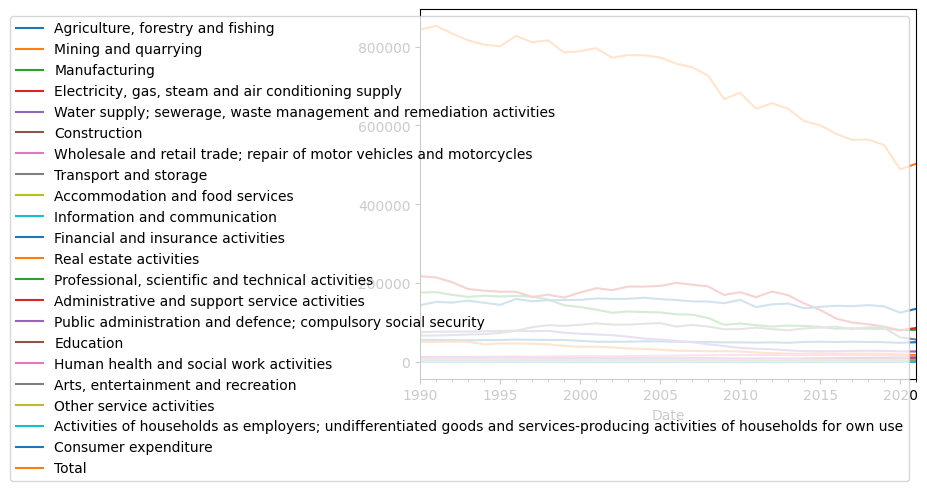

In [14]:
df1.plot()

In [15]:

columns_to_convert = ['Total']

df[columns_to_convert] = df[columns_to_convert].replace({',': '', '[^\d.]': ''}, regex=True).fillna(-1).apply(pd.to_numeric, errors='coerce')

problematic_column = columns_to_convert[0]
unique_values = df[problematic_column].unique()
for value in unique_values:
    print(f"Value: {value}, Type: {type(value)}")

Value: 842944.5, Type: <class 'numpy.float64'>
Value: 852556.4, Type: <class 'numpy.float64'>
Value: 833417.1, Type: <class 'numpy.float64'>
Value: 815888.7, Type: <class 'numpy.float64'>
Value: 804928.9, Type: <class 'numpy.float64'>
Value: 800882.1, Type: <class 'numpy.float64'>
Value: 827193.8, Type: <class 'numpy.float64'>
Value: 811315.7, Type: <class 'numpy.float64'>
Value: 815920.6, Type: <class 'numpy.float64'>
Value: 785099.1, Type: <class 'numpy.float64'>
Value: 788407.1, Type: <class 'numpy.float64'>
Value: 796129.5, Type: <class 'numpy.float64'>
Value: 771864.5, Type: <class 'numpy.float64'>
Value: 778528.0, Type: <class 'numpy.float64'>
Value: 777989.6, Type: <class 'numpy.float64'>
Value: 772538.9, Type: <class 'numpy.float64'>
Value: 756850.5, Type: <class 'numpy.float64'>
Value: 747966.2, Type: <class 'numpy.float64'>
Value: 726374.8, Type: <class 'numpy.float64'>
Value: 666850.0, Type: <class 'numpy.float64'>
Value: 682896.5, Type: <class 'numpy.float64'>
Value: 642747

In [16]:
len(df)

32

In [17]:
train = df.iloc[:26]
test = df.iloc[26:]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
df.head(),df.tail()

(               Total
 Date                
 1990-01-01  842944.5
 1991-01-01  852556.4
 1992-01-01  833417.1
 1993-01-01  815888.7
 1994-01-01  804928.9,
                Total
 Date                
 2017-01-01  563160.5
 2018-01-01  564144.5
 2019-01-01  550583.9
 2020-01-01  488596.4
 2021-01-01  502786.6)

In [20]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


In [21]:
scaled_train[:10]

array([[0.96184771],
       [1.        ],
       [0.92403083],
       [0.85445577],
       [0.8109533 ],
       [0.79489043],
       [0.89932884],
       [0.83630427],
       [0.85458239],
       [0.73224334]])

In [22]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)



In [23]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predicy this y: \n{y}')

Given the Array: 
[0.96184771 1.         0.92403083]
Predicy this y: 
[[0.85445577]]


In [24]:
X.shape

(1, 3, 1)

In [25]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.fit(generator, epochs=30)


Epoch 1/30
23/23 [==============================] - 1s 3ms/step - loss: 0.3607
Epoch 2/30
23/23 [==============================] - 0s 2ms/step - loss: 0.2131
Epoch 3/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0734
Epoch 4/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 5/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 6/30
23/23 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 7/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 8/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 10/30
23/23 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 11/30
23/23 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 12/30
23/23 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 13/30
23/23 [==============================

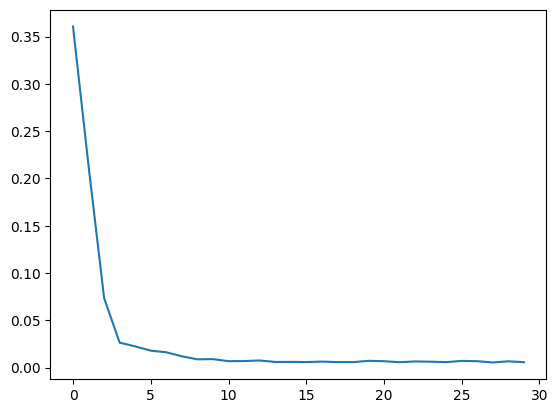

In [28]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [29]:
last_train_batch = scaled_train[-3:]

In [30]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 129ms/step


array([[-0.03716825]], dtype=float32)

In [32]:
scaled_test[0]

array([-0.08630755])

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


In [34]:
test_predictions

[array([-0.03716825], dtype=float32),
 array([-0.1021025], dtype=float32),
 array([-0.1366227], dtype=float32),
 array([-0.16271508], dtype=float32),
 array([-0.18452531], dtype=float32),
 array([-0.19691962], dtype=float32)]

In [44]:
test[:32]

,Total,Predictions
Date,,
2016-01-01,578877.4,591257.313348
2017-01-01,563160.5,574898.097528
2018-01-01,564144.5,566201.247140
2019-01-01,550583.9,559627.660704
2020-01-01,488596.4,554132.897322
2021-01-01,502786.6,551010.335834


In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

<ipython-input-37-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

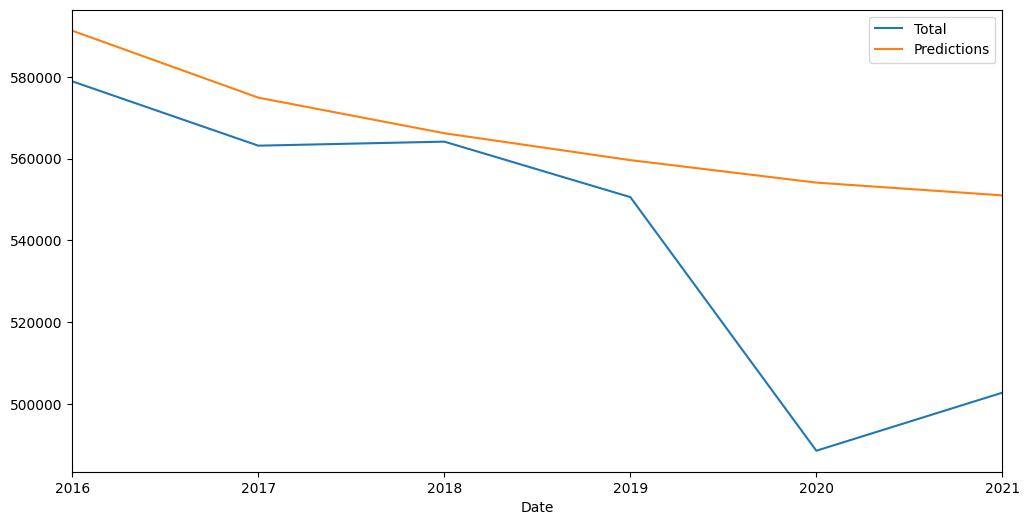

In [38]:
test.plot(figsize=(12,6))

In [39]:

rmse=sqrt(mean_squared_error(test['Total'],test['Predictions']))
print(rmse)

34150.68190091379


Root Mean Squared Error (RMSE): 34150.68190091379
Mean Absolute Error (MAE): 24829.708646103583
Mean Absolute Percentage Error (MAPE): 4.87%


<ipython-input-40-1d6d055bd0bc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


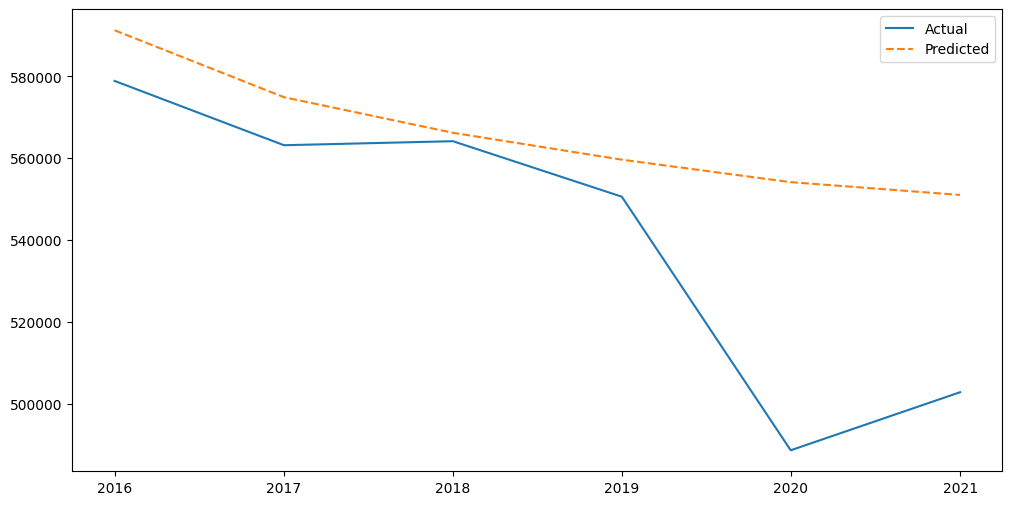

In [40]:
rmse = np.sqrt(mean_squared_error(test['Total'], true_predictions.flatten()))
mae = mean_absolute_error(test['Total'], true_predictions.flatten())
mape = np.mean(np.abs((test['Total'] - true_predictions.flatten()) / test['Total'])) * 100

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

test['Predictions'] = true_predictions
plt.figure(figsize=(12, 6))
plt.plot(test['Total'], label='Actual')
plt.plot(test['Predictions'], label='Predicted', linestyle='dashed')
plt.legend()
plt.show()

In [41]:
current_batch.shape

(1, 3, 1)

1/1 [==============================] - ETA: 0s

<ipython-input-50-286cd422b25c>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  future_dates = pd.date_range(start='01-01-2022', end='31-12-2026', freq='Y')


1/1 [==============================] - 0s 14ms/step


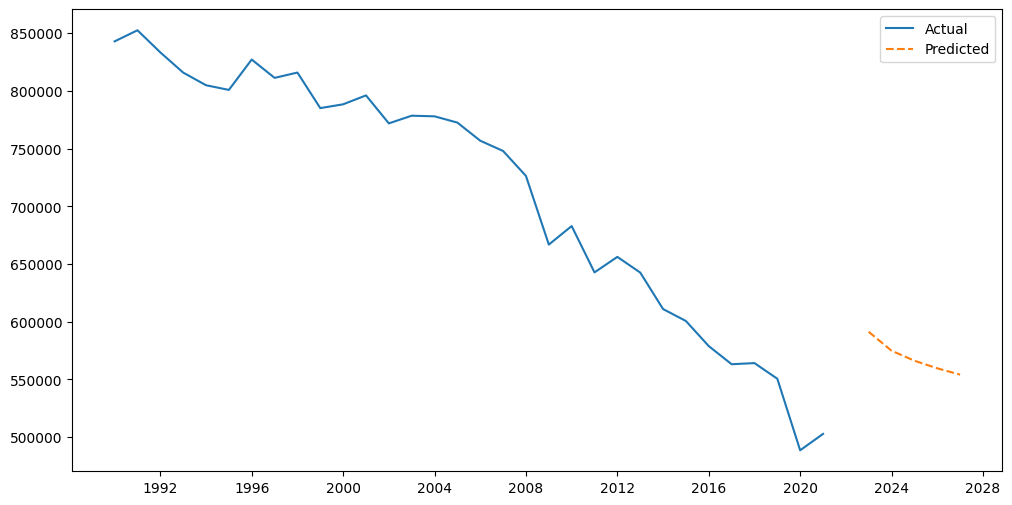

In [50]:

future_dates = pd.date_range(start='01-01-2022', end='31-12-2026', freq='Y')


future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted_Value'])

current_batch = scaled_train[-n_input:].reshape((1, n_input, n_features))


current_batch = scaled_train[-n_input:].reshape((1, n_input, n_features))


for i in range(len(future_dates)):
    current_pred = model.predict(current_batch)[0]
    future_predictions.loc[future_dates[i], 'Predicted_Value'] = current_pred
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)


true_future_predictions = scaler.inverse_transform(future_predictions[['Predicted_Value']])

df_extended = pd.concat([df, pd.DataFrame(index=future_dates)], axis=0)
df_extended['Predictions'] = np.nan
df_extended['Predictions'].iloc[-len(future_dates):] = true_future_predictions.flatten()


plt.figure(figsize=(12, 6))
plt.plot(df_extended['Total'], label='Actual')
plt.plot(df_extended['Predictions'], label='Predicted', linestyle='dashed')
plt.legend()
plt.show()


In [51]:
for i in range(len(future_dates)):

    current_pred_scaled = model.predict(current_batch)[0]

    current_pred = scaler.inverse_transform(current_pred_scaled.reshape(1, -1))[0][0]

    future_predictions.loc[future_dates[i], 'Predicted_Value'] = current_pred

    print(f'Prediction for {future_dates[i]}: {current_pred}')

    current_batch = np.append(current_batch[:, 1:, :], [[current_pred_scaled]], axis=1)

1/1 [==============================] - 0s 14ms/step
Prediction for 2022-12-31 00:00:00: 551010.375
1/1 [==============================] - 0s 14ms/step
Prediction for 2023-12-31 00:00:00: 548922.875
1/1 [==============================] - 0s 14ms/step
Prediction for 2024-12-31 00:00:00: 547477.6875
1/1 [==============================] - 0s 14ms/step
Prediction for 2025-12-31 00:00:00: 546657.0
1/1 [==============================] - 0s 17ms/step
Prediction for 2026-12-31 00:00:00: 546124.0625
